In [1]:
using DifferentialEquations, Plots, ReferenceFrameRotations, FiniteDiff, ForwardDiff

In [2]:
# This code is for simulating a chain of N points.
# This is to emulate a receptor where the points represent
# the hinges.
# Each hinge can have a defined potential in the local
# spherical coordinates, which is converted to global 
# Cartesian via rotation quaternions and directional cosine
# matrices.
# The simulation is carried out in the global Cartesian
# coordinate system.

# Define some basic coordinate identities
function CartesianToSpherical(X::Vector)
    r = sqrt(X[1]^2 + X[2]^2 + X[3]^2)
    θ = angle(X[1] + im*X[2])
    ϕ = acos(X[3]/r)
    return [r,θ,ϕ]
end

function SphericalToCartesian(Φ::Vector)
    x = Φ[1]*cos(Φ[2])*sin(Φ[3])
    y = Φ[1]*sin(Φ[2])*sin(Φ[3])
    z = Φ[1]*cos(Φ[3])
    return [x,y,z]
end

function StCθ(Φ::Vector)
    x = - Φ[1]*sin(Φ[2])*sin(Φ[3])
    y = Φ[1]*cos(Φ[2])*sin(Φ[3])
    z = 0
    return [x,y,z]
end

function StCϕ(Φ::Vector)
    x = Φ[1]*cos(Φ[2])*cos(Φ[3])
    y = Φ[1]*sin(Φ[2])*cos(Φ[3])
    z = - Φ[1]*sin(Φ[3])
    return [x,y,z]
end

function StCr(Φ::Vector)
    x = cos(Φ[2])*sin(Φ[3])
    y = sin(Φ[2])*sin(Φ[3])
    z = cos(Φ[3])
    return [x,y,z]
end

# Find the directional cosine matrix (DCM) for a given set of angles and
# a set of initial basis vectors.
function FindDCM(θ,ϕ,K::Matrix{Float64})
    I3 = 1.0*Matrix(I,3,3)
    qϕ = Quaternion(cos(ϕ/2), sin(ϕ/2)*K[2,:]) # Rotate by ϕₙ' around ŷ(n-1)
    qθ = Quaternion(cos(θ/2), sin(θ/2)*K[3,:]) # Rotate by θₙ' around ẑ(n-1)
    q = qθ*qϕ

    for n in 1:3
        K[n,:] = vect(q*K[n,:]/q)
    end
    
    return [I3[n,:]' * K[m,:] for n in 1:3, m in 1:3], K, [qθ,qϕ]
end

# Algorithm to convert Cartesian coordinates of hinge points and find 
# their local spherical coordinates.
function FindLocals(X::Matrix)
    Locals = reshape(CartesianToSpherical(X[1,:]),1,3)
    # D, K, q = FindDCM(Locals[1,2], Locals[1,3], 1.0*Matrix(I,3,3))
    DCMs = [1.0*Matrix(I,3,3)]
    KList = [1.0*Matrix(I,3,3)]
    Q = reshape([],2,0)
    
    for n in 2:size(X)[1]
        Locals = [Locals; CartesianToSpherical(DCMs[end]' * (X[n,:] - X[n-1,:]))']
        D, K, q = FindDCM(Locals[n,2], Locals[n,3], copy(KList[end]))
        push!(DCMs, copy(D))
        push!(KList, copy(K))
        Q = hcat(Q, q)
    end
    
    return Locals, DCMs, KList, Q
end

function FindCartesians(Φ::Matrix)
    D, K = 1.0*Matrix(I,3,3), 1.0*Matrix(I,3,3) # FindDCM(Φ[1,2], Φ[1,3], 1.0*Matrix(I,3,3))
    DCMs = [copy(D)]
    Carts = reshape(SphericalToCartesian(Φ[1,:]),1,3)

    for n in 2:size(Φ,1)
        D, K = FindDCM(Φ[n,2], Φ[n,3], K)
        Carts = [Carts; reshape(Carts[n-1,:] + DCMs[n-1]*SphericalToCartesian(Φ[n,:]),1,3)]
        push!(DCMs, copy(D))
    end

    return Carts
end

# Calculate the Jacobian of dΦ = J*dX
# Having SingularException errors, I don't think this Jacobian is invertible
# Theoretically, I think it should be invertible but I will need to check
# Can always do the Jacobian for dX = J*dΦ
function NumericalJacobian(f::Function, X::Matrix, h)
    function C(m,N,h)
        Matrix = zeros(3,N)
        Matrix[m] = h
        return copy(Matrix')
    end

    N = size(X,1)
    M = size(X,2) # Should be = 3
    return [(f(X+C(m,N,h/2))'[n] - f(X-C(m,N,h/2))'[n])/h for n in 1:N*M, m in 1:N*M ]
end

# Analytically calculated the Jacobian (this is incorrect)
Jac(Φ::Vector) = [cos(Φ[2])*sin(Φ[3]) -Φ[1]*sin(Φ[2])*sin(Φ[3]) Φ[1]*cos(Φ[2])*cos(Φ[3]);
                  sin(Φ[2])*sin(Φ[3])  Φ[1]*cos(Φ[2])*sin(Φ[3]) Φ[1]*sin(Φ[2])*cos(Φ[3]);
                      cos(Φ[3])                    0                -Φ[1]*sin(Φ[3])     ]

function AnalyticalJacobian(Φ, DCMs)
    N = size(Φ,1) * 3
    J = zeros(N,N)
    DCMs = append!([1.0*Matrix(I,3,3)], DCMs) # Include D₀ at the start

    # Since D₀ is included, using DCMs[n] instead of DCMs[n-1]
    for n in 1:3:N
        for m in 1:3:N
            if m<=n
                J[n:n+2,m:m+2] = DCMs[div(n+2,3)]*Jac(Φ[div(m+2,3),1],Φ[div(m+2,3),2],Φ[div(m+2,3),3])
            end
        end
    end

    return J
end

function PackageJ(U,N)
    Temp = FiniteDiff.finite_difference_jacobian(FindCartesians, U)
    PackageJ = zeros(3*N,3*N)
    for n in 1:N
        PackageJ[3*n-2,:] = Temp[n,:]
        PackageJ[3*n-1,:] = Temp[N+n,:]
        PackageJ[3*n,:] = Temp[2*N+n,:]
    end
    Temp = copy(PackageJ)
    for n in 1:N
        PackageJ[:,3*n-2] = Temp[:,n]
        PackageJ[:,3*n-1] = Temp[:,N+n]
        PackageJ[:,3*n] = Temp[:,2*N+n]
    end
    return PackageJ
end

PackageJ (generic function with 1 method)

In [5]:
let 
    u = [0.0 0 eps(); 
          0 0 1;
          0 0 2;
          0 0 -1;
          0 0 -2]
    Φ, DMs, KList, Q = FindLocals(u)
    FiniteDiff.finite_difference_jacobian(FindCartesians, Φ)
end

15×15 Matrix{Float64}:
 0.0  0.0  0.0   0.0           0.0          0.0  …   0.0   0.0          0.0
 0.0  0.0  0.0   0.0           0.0          0.0      0.0   0.0          0.0
 0.0  0.0  0.0   0.0           0.0          0.0      1.0   0.0          0.0
 0.0  0.0  0.0   1.22465e-16   0.0          0.0     -2.0  -3.0          0.0
 0.0  0.0  0.0   1.22465e-16   1.22465e-16  0.0     -3.0  -4.0         -1.0
 0.0  0.0  0.0   0.0           0.0          0.0  …   0.0   0.0          0.0
 0.0  0.0  0.0   0.0           0.0          0.0      0.0   0.0          0.0
 0.0  0.0  0.0   0.0           0.0          0.0      0.0   0.0          0.0
 0.0  0.0  0.0   0.0           0.0          0.0      0.0   0.0          0.0
 0.0  0.0  0.0   0.0           0.0          0.0      0.0   0.0          0.0
 1.0  0.0  0.0   0.0           0.0          0.0  …   0.0   0.0          0.0
 1.0  1.0  0.0   0.0           0.0          0.0      0.0   0.0          0.0
 1.0  1.0  1.0   0.0           0.0          0.0      0.0   0.0   

In [21]:
function AJ(Φ,K,Q,N)
    # Initialise sub-Jacobians
    Jacobian = zeros(3*N,3*N)
    dUnits = [ zeros(3,1) for l in 1:6 ] # Zeroes represent the derivatives of the 0th frame
    # append!([1.0*Matrix(I,3,3)], K) # The identity matrix is the 0th frame, but 1st in this list
    # append!([1.0*Quaternion(1,0,0,0)], Q) # The identity quaternion is of the 0th frame, but 1st in this list

    # Each K has form [x';y';z'], so need to take transpose to get form of [x y z]
    K = [copy(K[l]') for l in 1:length(K)]

    # dUnits are organised in the list as:
    # 1: dx/dθ, 2: dy/dθ, 3: dz/dθ
    # 4: dx/dϕ, 5: dy/dϕ, 6: dz/dϕ

    # Calculate diagonals
    for m in 1:N-1
        # Construct the first entry of the unit vector matrix column
        for l in 1:3
            # θ derivatives
            TempUnit = vect(Quaternion(K[m][3,:]) * Quaternion(K[m+1][l,:]) - Quaternion(K[m+1][l,:]) * Quaternion(K[m][3,:])) / 2
            dUnits[l] = hcat(dUnits[l], TempUnit)
            
            # ϕ derivatives
            TempUnit = vect(Q[m] * (Quaternion(K[m][2,:]) * Quaternion(K[m][l,:]) - Quaternion(K[m][l,:]) * Quaternion(K[m][2,:])) / Q[m]) / 2
            dUnits[l+3] = hcat(dUnits[l+3], TempUnit)
        end

        # Fill out the rest of column below the first entry (all 0's above)
        if m < N
            for n in m+1:N-1
                for l in 1:3
                    # θ derivatives
                    TempUnit = 1/2 * vect( Q[n]*(Φ[n+1,2]*dUnits[3][:,end] + Φ[n+1,3]*dUnits[2][:,end])/Q[n] 
                                         - Quaternion(K[n+1][l,:])*(Φ[n+1,2]*dUnits[3][:,end] + Φ[n+1,3]*dUnits[2][:,end]) 
                                         + Q[n]*dUnits[l][:,end]/Q[n])
                    dUnits[l] = hcat(dUnits[l], TempUnit)

                    # ϕ derivatives
                    TempUnit = 1/2 * vect( Q[n]*(Φ[n+1,2]*dUnits[6][:,end] + Φ[n+1,3]*dUnits[5][:,end])/Q[n] 
                                         - Quaternion(K[n+1][l,:])*(Φ[n+1,2]*dUnits[6][:,end] + Φ[n+1,3]*dUnits[5][:,end]) 
                                         + Q[n]*dUnits[l+3][:,end]/Q[n])
                    dUnits[l+3] = hcat(dUnits[l+3], TempUnit)
                end
            end
        end

        # Now fill out the Jacobian column
        for n in m:N-1
            Jacobian[3*n+1:3*n+3, 3*m+1] = K[m]*StCr(Φ[m+1,:])

            FirstTerm = sum( [copy([dUnits[1][:,k] dUnits[2][:,k] dUnits[3][:,k]]')*SphericalToCartesian(Φ[k+1,:]) for k in 1:n] )
            SecondTerm = K[m]*StCθ(Φ[m+1,:])
            Jacobian[3*n+1:3*n+3, 3*m+2] = FirstTerm + SecondTerm

            FirstTerm = sum( [copy([dUnits[4][:,k] dUnits[5][:,k] dUnits[6][:,k]]')*SphericalToCartesian(Φ[k+1,:]) for k in 1:n] )
            SecondTerm = K[m]*StCϕ(Φ[m+1,:])
            Jacobian[3*n+1:3*n+3, 3*m+3] = FirstTerm + SecondTerm
        end
    end

    for n in 1:N
        Jacobian[3*n-2:3*n, 1:3] = Jac(Φ[1,:])
    end

    return Jacobian
end

AJ (generic function with 1 method)

In [93]:
let 
    Q = Quaternion([1/sqrt(2),0,1/sqrt(2),0])
    T1 = pi/2*Q*[-1,0,0]*[0,0,-1]/Q
    T2 = pi/2*Quaternion([-1,0,0])*[-1,0,0]
    T1 + T2
    Q*[0,0,-1]/Q*[-1,0,0]
end

Quaternion{Float64}:
  - 1.0 + 0.0⋅i + 0.0⋅j + 0.0⋅k

In [84]:
let
    function AJ(Φ,K,q,N)
        # Initialise sub-Jacobians
        Jacobian = zeros(3*N,3*N)
        # append!([1.0*Matrix(I,3,3)], K) # The identity matrix is the 0th frame, but 1st in this list
        # append!([1.0*Quaternion(1,0,0,0)], Q) # The identity quaternion is of the 0th frame, but 1st in this list
        Q = [q[1,n]*q[2,n] for n in 1:size(q,2)]
        display(Q)
    
        # Each K has form [x';y';z'], so need to take transpose to get form of [x y z]
        K = [copy(K[l]') for l in 1:length(K)]
    
        # dUnits are organised in the list as:
        # 1: dx/dθ, 2: dy/dθ, 3: dz/dθ
        # 4: dx/dϕ, 5: dy/dϕ, 6: dz/dϕ
        
        # Calculate diagonals
        for m in 1:N-1
            # Construct the first entry of the unit vector matrix column
            dUnits = [ zeros(3,m) for l in 1:6 ]
            for l in 1:3
                # θ derivatives
                TempUnit = (Quaternion(K[m][:,3]) * Quaternion(K[m+1][:,l]) - Quaternion(K[m+1][:,l]) * Quaternion(K[m][:,3])) / 2
                dUnits[l] = hcat(dUnits[l], vect(TempUnit))
                
                # ϕ derivatives
                TempUnit = (Q[m] * (Quaternion(K[m][:,2]) * Quaternion(K[m][:,l]) - Quaternion(K[m][:,l]) * Quaternion(K[m][:,2])) / Q[m]) / 2
                dUnits[l+3] = hcat(dUnits[l+3], vect(TempUnit))
            end

            # Fill out the rest of column below the first entry (all 0's above)
            if m < N-2
                display("Further derivatives:")
                for n in m+1:N-1
                    for l in 1:3
                        # θ derivatives
                        TempUnit =  (Φ[n,2]*(q[1,n]*dUnits[3][:,n]*q[2,n]*K[n][:,l]/Q[n] - Quaternion(K[n+1][:,l])*dUnits[3][:,n]) + 
                                    Φ[n,3]*(Q[n]*dUnits[2][:,n]*Quaternion(K[n][:,l])/Q[n] - Q[n]*K[n][:,l]/q[2,n]*dUnits[2][:,n]/q[1,n]) + 
                                    2*Q[n]*dUnits[l][:,n]/Q[n])/2
                        display(dUnits[2][:,n]*Quaternion(K[n][:,l]))
                        dUnits[l] = hcat(dUnits[l], vect(TempUnit))

                        # ϕ derivatives
                        TempUnit =  (Φ[n,2]*(q[1,n]*dUnits[6][:,n]*q[2,n]*K[n][:,l]/Q[n] - Quaternion(K[n+1][:,l])*dUnits[6][:,n]) + 
                                    Φ[n,3]*Q[n]*(dUnits[5][:,n]*Quaternion(K[n][:,l])/Q[n] - Quaternion(K[n][:,l])/q[2,n]*dUnits[5][:,n]/q[1,n]) + 
                                    2*Q[n]*dUnits[l][:,n]/Q[n])/2
                        dUnits[l+3] = hcat(dUnits[l+3], vect(TempUnit))
                    end
                end
                display("-------")
            end
            # display("dUnits:")
            # display(dUnits[2])
            # display("-----")
    
            # Now fill out the Jacobian column
            for n in m:N-1              
                if m+1>n
                    Jacobian[3*n+1:3*n+3, 3*m+1:3*m+3] = K[m]*Jac(Φ[m+1,:])
                else
                    # display([n,m])
                    # display(dUnits[2])
                    # display([[dUnits[1][:,k] dUnits[2][:,k] dUnits[3][:,k]] for k in m+1:n][1])
                    # display([SphericalToCartesian(Φ[k+1,:]) for k in m+1:n][1])

                    Jacobian[3*n+1:3*n+3, 3*m+1] = K[m]*StCr(Φ[m+1,:])
                    
                    # display([copy([dUnits[1][:,k] dUnits[2][:,k] dUnits[3][:,k]]) for k in 1:n-m])
                    FirstTerm = sum( [copy([dUnits[1][:,k] dUnits[2][:,k] dUnits[3][:,k]])*SphericalToCartesian(Φ[k+1,:]) for k in m+1:n] )
                    SecondTerm = K[m]*StCθ(Φ[m+1,:])
                    Jacobian[3*n+1:3*n+3, 3*m+2] = FirstTerm + SecondTerm
                    
                    FirstTerm = sum( [copy([dUnits[4][:,k] dUnits[5][:,k] dUnits[6][:,k]])*SphericalToCartesian(Φ[k+1,:]) for k in m+1:n] )
                    SecondTerm = K[m]*StCϕ(Φ[m+1,:])
                    Jacobian[3*n+1:3*n+3, 3*m+3] = FirstTerm + SecondTerm
                end
                # if n == m
                #     DispJ = Jacobian[3*n+1:3*n+3, 3*m+1:3*m+3]
                #     DispJ[abs.(DispJ) .< 1e-8] .= 0
                #     DispP = PackageJ(Φ,N)[3*n+1:3*n+3, 3*m+1:3*m+3]
                #     DispP[abs.(DispP) .< 1e-8] .= 0
                #     display(3*n+1)
                #     display(DispJ)
                #     display(DispP)
                #     # display(StCr(Φ[m+1,:]))
                # end
            end
        end
    
        for n in 1:N
            Jacobian[3*n-2:3*n, 1:3] = Jac(Φ[1,:])
        end

        return Jacobian
    end

    X =  rand(4,3) # [0 0 1; 1 0 1; 1 0 0; 0 0 0]
    N = size(X,1)
    Φ, DMs, KList, Q = FindLocals(X)
    J = AJ(Φ,KList,Q,N)
    # J[abs.(J) .< 1e-5] .= 0
    P = PackageJ(Φ,N)
    # P[abs.(P) .< 1e-5] .= 0
    D = J - P
    D[abs.(D) .< 1e-5] .= 0

    show(IOContext(stdout, :limit=>false), MIME"text/plain"(), D[4:end,4:end])
    # show(IOContext(stdout, :limit=>false), MIME"text/plain"(), AJ(Φ,KList,Q,N))
    # show(IOContext(stdout, :limit=>false), MIME"text/plain"(), PackageJ(Φ,N)[4:end,4:end])
end

3-element Vector{Quaternion{Float64}}:
 Quaternion{Float64}: + 0.189797 + 0.799821⋅i + 0.324329⋅j - 0.468053⋅k
 Quaternion{Float64}: + 0.296747 + 0.770968⋅i + 0.558283⋅j + 0.0766125⋅k
 Quaternion{Float64}: + 0.422814 - 0.339535⋅i + 0.634859⋅j - 0.550363⋅k

"Further derivatives:"

Quaternion{Float64}:
  - 0.489806 - 0.607213⋅i + 0.625605⋅j + 5.55112e-17⋅k

Quaternion{Float64}:
  + 0.0 - 3.86624e-17⋅i + 3.98335e-17⋅j - 1.0⋅k

Quaternion{Float64}:
  + 0.871831 - 0.341141⋅i + 0.351473⋅j - 5.55112e-17⋅k

Quaternion{Float64}:
  - 1.11782 - 0.355737⋅i + 0.833188⋅j - 0.57854⋅k

Quaternion{Float64}:
  - 3.33067e-16 - 1.07034⋅i - 0.911516⋅j - 0.654587⋅k

Quaternion{Float64}:
  - 1.07492 + 0.369932⋅i - 0.866436⋅j + 0.601626⋅k

"-------"

9×9 Matrix{Float64}:
 0.0   0.0        0.0       0.0  0.0  0.0  0.0  0.0  0.0
 0.0   0.0        0.0       0.0  0.0  0.0  0.0  0.0  0.0
 0.0   0.0        0.0       0.0  0.0  0.0  0.0  0.0  0.0
 0.0   0.0        0.0       0.0  0.0  0.0  0.0  0.0  0.0
 0.0   0.0        0.0       0.0  0.0  0.0  0.0  0.0  0.0
 0.0   0.0        0.0       0.0  0.0  0.0  0.0  0.0  0.0
 0.0   0.52539    0.360282  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  -0.670191  -0.457251  0.0  0.0  0.0  0.0  0.0  0.0
 0.0   0.460059   0.311354  0.0  0.0  0.0  0.0  0.0  0.0

In [229]:
let 
    Q = Quaternion(rand(4))
    Q*Quaternion(rand(3))/Q
end

Quaternion{Float64}:
  + 4.16334e-17 + 0.181447⋅i + 0.907117⋅j + 0.417176⋅k

In [4]:
k = 10
κ = 1000
D = 0.1
R = 1
N = 5

t0 = 0.0
tf = 1
dt = 1//1000

function LocalV(u)
    # Insert localised potentials' (i.e. force) here
    # Function of (r,θ,ϕ)ₙ' for all n ∈ [1,N]
    du = zeros(length(u))
    
    # These first 3 represent the centre of the virus
    du[1] = 0 # -κ*(u[4] - R)  # r₀'
    du[2] = 0              # θ₀'
    du[3] = 0              # ϕ₀'

    # The second 3 represent the base of the receptor
    du[4] = -κ*(u[4] - R) - κ*(u[7] - R)
    du[5] = 0
    du[6] = 0

    for n in 7:3:3*N-3
        du[n] = -κ*(u[n]-R) - κ*(u[n+3]-R)
        du[n+1] = 0
        du[n+2] = -k*u[n+2]
    end

    du[end-2] = -κ*(u[end-2]-R)
    du[end-1] = 0
    du[end] = -k*u[end]

    return du
end

function det(du,u,p,t)
    Φ, DMs, KList, Q = FindLocals(copy(reshape(u,3,N)'))
    Φ_vect = reshape(copy(Φ'),3*N)
    V = LocalV(Φ_vect)   # Define potential' (force) in terms of local spherical
    # V = AnalyticalJacobian(Φ, DMs) * V
    # V = NumericalJacobian(FindCartesians, Φ, 1e-5) * V  # Convert to global Cartesian
    V = PackageJ(Φ,N) * V
    # V = AJ(Φ,KList,Q,N) * V

    # if mod(trunc(t/dt),trunc(tf/dt/5)) == 0
    #     display(trunc(1000*t))
    #     # display(AJ(Φ,KList,Q,N) - NumericalJacobian(FindCartesians, Φ, 1e-5))
    #     show(IOContext(stdout, :limit=>false), MIME"text/plain"(), AJ(Φ,KList,Q,N) - PackageJ(Φ,N))
    #     # display(NumericalJacobian(FindCartesians, Φ, 1e-5) - FiniteDiff.finite_difference_jacobian(FindCartesians, Φ))
    #     # show(IOContext(stdout, :limit=>false), MIME"text/plain"(), NumericalJacobian(FindCartesians, Φ, 1e-5))
    #     # display(AJ(Φ,KList,Q,N))
    #     # display(FiniteDiff.finite_difference_jacobian(FindCartesians, Φ))
    # end

    du[1:end] = V[1:end]
end

function stoch(du,u,p,t)
    du[1:3] .= 0
    du[4:6] .= sqrt(6*D)
    du[7:end] .= sqrt(2*D)
end

TimeRange = range(t0,tf,step = dt)[1:end-1]
prob_sde_lorenz = SDEProblem(det,stoch,[0,0,1,0,0,2,0,0,3,0,0,4,0,0,5],(t0,tf))
display("Problem defined")
sol = solve(prob_sde_lorenz,EM(),dt=dt)
display("Problem solved")

SN = []

for i in 1:N
    push!(SN, [sol.u[n][m] for n in 1:length(sol), m in 1+3*(i-1):3+3*(i-1)])
end

plotly()
P = plot(SN[1][:,1], SN[1][:,2], SN[1][:,3],
    legend = :none,
    xlabel="x",
    ylabel="y",
    zlabel="z")

for n in 2:N
    plot!(SN[n][:,1], SN[n][:,2], SN[n][:,3])
end
display(P)

"Problem defined"

"Problem solved"

┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots C:\Users\Liam\.julia\packages\Plots\YAlrZ\src\backends.jl:432


┌ Info: Saved animation to 
│   fn = c:\Users\Liam\Documents\PhD\Research\Scripts\StochasticSimulations\tmp.gif
└ @ Plots C:\Users\Liam\.julia\packages\Plots\YAlrZ\src\animation.jl:114


Plots.AnimatedGif("c:\\Users\\Liam\\Documents\\PhD\\Research\\Scripts\\StochasticSimulations\\tmp.gif")
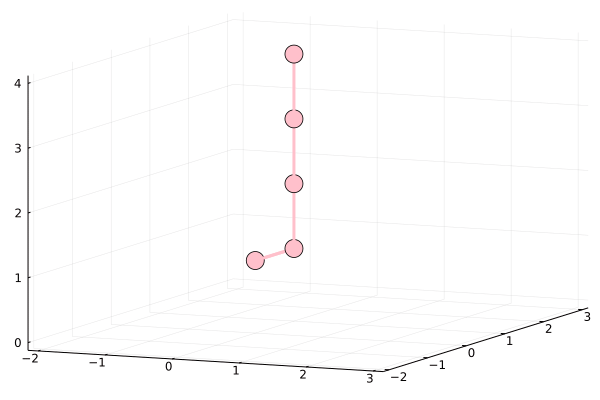

In [7]:
gr()
@gif for n in 1:length(sol.t)
    plot([SN[1][n,1],SN[2][n,1]], [SN[1][n,2],SN[2][n,2]], [SN[1][n,3],SN[2][n,3]],
    legend = :none,
    xlims = [-2, 3],
    ylims = [-2, 3],
    zlims = [0, 4],
    c=:pink,
    lw = 3
    )
    scatter!([SN[1][n,1]], [SN[1][n,2]], [SN[1][n,3]], c=:pink, ms=10)
    for i in 2:N
        plot!([SN[i-1][n,1],SN[i][n,1]], [SN[i-1][n,2],SN[i][n,2]], [SN[i-1][n,3],SN[i][n,3]], c=:pink, lw=3)
        scatter!([SN[i][n,1]], [SN[i][n,2]], [SN[i][n,3]], c=:pink, ms=10)
    end
end every 10